In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
# Basic libraries
import sys
import os
import gc
import time              
import pickle                
import numpy as np
import pandas as pd
from time import time

# Data visualization & printing libraries
from matplotlib import pyplot as plt
import seaborn as sb
from PIL import Image
from IPython.display import HTML, display
import tabulate

# Deep learning libraries
import tensorflow as tf
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import Flatten, Activation, Input, AveragePooling2D, Lambda, add
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utility functions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle

# Setting random seeds
np.random.seed(7)
tf.random.set_seed(7)

# Magic functions
%matplotlib inline

2024-02-04 06:35:28.954938: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 06:35:28.955055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 06:35:29.244759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
if tf.test.is_gpu_available():
    # Get the list of available GPUs
    gpu_devices = tf.config.list_physical_devices('GPU')
    
    # Display GPU information
    for gpu_device in gpu_devices:
        print("GPU device name:", gpu_device.name)
else:
    print("GPU not available. TensorFlow is running on CPU.")


TensorFlow version: 2.15.0
GPU device name: /physical_device:GPU:0
GPU device name: /physical_device:GPU:1


In [4]:
from tensorflow.python.client import device_lib 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')),'\n')
print(device_lib.list_local_devices(),'\n')
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  2 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15789676522712165063
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7206458890835432417
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16302095898240968840
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
] 

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [5]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [6]:
# Getting image paths and creating pandas dataframe for each dataset (train/val/test)

train_p = [('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'))]
train_n = [('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('../input/chest-xray-pneumonia/chest_xray/train/NORMAL'))]
val_p = [('../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA'))]
val_n = [('../input/chest-xray-pneumonia/chest_xray/val/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('../input/chest-xray-pneumonia/chest_xray/val/NORMAL'))]
test_p = [('../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'))]
test_n = [('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('../input/chest-xray-pneumonia/chest_xray/test/NORMAL'))]

train_data = pd.DataFrame(train_p+train_n, columns=['image_path', 'label'],index=None)
val_data = pd.DataFrame(val_p+val_n, columns=['image_path', 'label'],index=None)
test_data = pd.DataFrame(test_p+test_n, columns=['image_path', 'label'],index=None)

In [7]:
print("The head of the training dataframe:")
train_data.head()

The head of the training dataframe:


image_path  label
0  ../input/chest-xray-pneumonia/chest_xray/train...      1
1  ../input/chest-xray-pneumonia/chest_xray/train...      1
2  ../input/chest-xray-pneumonia/chest_xray/train...      1
3  ../input/chest-xray-pneumonia/chest_xray/train...      1
4  ../input/chest-xray-pneumonia/chest_xray/train...      1

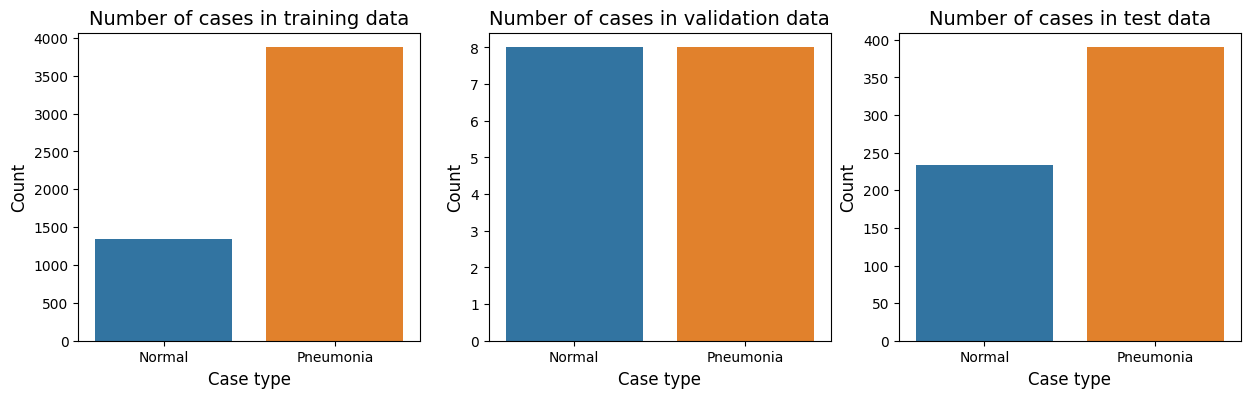

In [8]:
# Count plot of the class representations.

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sb.countplot(data= train_data, x='label')
plt.title('Number of cases in training data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_data.label.unique())), ['Normal', 'Pneumonia'])

plt.subplot(1,3,2)
sb.countplot(data= val_data, x='label')
plt.title('Number of cases in validation data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(val_data.label.unique())), ['Normal', 'Pneumonia'])

plt.subplot(1,3,3)
sb.countplot(data= test_data, x='label')
plt.title('Number of cases in test data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(test_data.label.unique())), ['Normal', 'Pneumonia']);

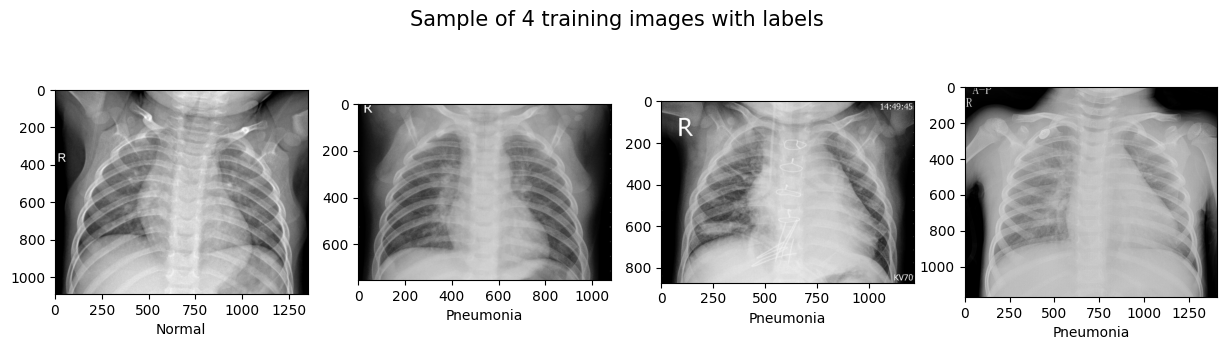

In [9]:
# Visualizing a sample of 4 training images.

random_imgs = np.random.randint(1,train_data.shape[0],4)
plt.figure(figsize=(15,4))
plt.suptitle('Sample of 4 training images with labels', y=0.95,fontsize=15)
for i, img in enumerate(train_data.iloc[random_imgs,0]):
    image_temp = Image.open(img)                                           # Conversion to Black & White
    plt.subplot(1,4,i+1)
    plt.imshow(image_temp, cmap='gray')
    if train_data.iloc[random_imgs[i],1] == 0:
        plt.xlabel('Normal')
    else:
        plt.xlabel('Pneumonia')

In [10]:
# Creating a dataframe for image properties.

l = []
path_list = train_p + train_n + val_p + val_n + test_p + test_n
for i in path_list:
    with Image.open(i[0]) as image_temp:
        l.append(list(np.asarray(image_temp).shape))
imgs_size_df = pd.DataFrame(l, columns=['height', 'width', 'channels'], index=None)
imgs_size_df['channels'].fillna(1, inplace=True)  # Modified line to address FutureWarning


/tmp/ipykernel_28/640050885.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imgs_size_df['channels'].fillna(1, inplace=True)  # Modified line to address FutureWarning


Image size: (516, 895, 3)


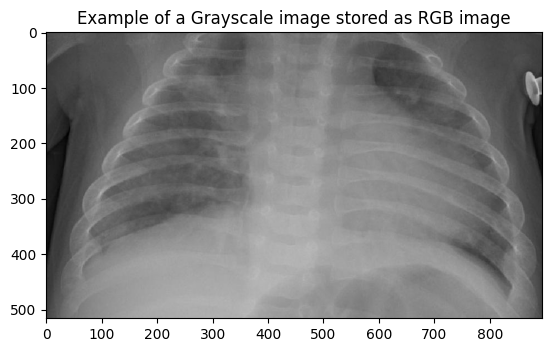

In [11]:
# Example of B&W image stored in RGB format

img = Image.open(path_list[imgs_size_df.query('channels==3').index[0]][0])
plt.imshow(img)
plt.title('Example of a Grayscale image stored as RGB image')
print('Image size:', np.asarray(img).shape)

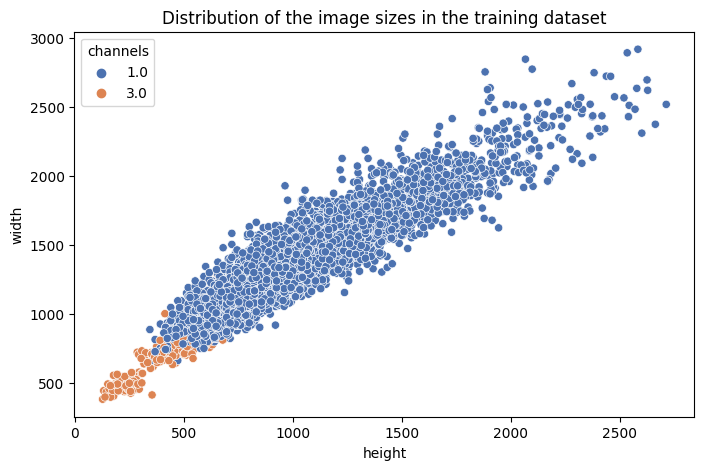

In [12]:
plt.figure(figsize=(8,5))
sb.scatterplot(data=imgs_size_df, x='height', y='width', hue='channels', palette="deep")
plt.title('Distribution of the image sizes in the training dataset');

In [13]:
imgs_size_df.fillna(value=int(1), inplace=True)
imgs_size_df.query('channels==3').head()
print('There are', imgs_size_df.query('channels==3').shape[0], 'B&W images stored in RGB format.')

There are 283 B&W images stored in RGB format.


In [14]:
# Resizing all the images: New size 256x256

direct_lists=[train_p,train_n,val_p,val_n,test_p,test_n]
save_paths=['/kaggle/working/modified/train/PNEUMONIA/',
            '/kaggle/working/modified/train/NORMAL/',
            '/kaggle/working/modified/val/PNEUMONIA/',
            '/kaggle/working/modified/val/NORMAL/',
            '/kaggle/working/modified/test/PNEUMONIA/',
            '/kaggle/working/modified/test/NORMAL/']

for path in save_paths:
    os.makedirs(path)

In [15]:
save_prefix=['train_pneumonial','train_normal','val_pneumonial','val_normal','test_pneumonial','test_normal']
for direct,save_path,prefix in zip(direct_lists,save_paths, save_prefix):
    i=1
    for path in direct:
        with Image.open(path[0]) as img_temp:
            resized_gray = img_temp.resize((256,256)).convert('L')
            resized_gray.save(save_path+prefix+'_'+str(i)+'.jpg')
        i+=1

In [16]:
# Modified image paths

train_p = [('/kaggle/working/modified/train/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('/kaggle/working/modified/train/PNEUMONIA/'))]
train_n = [('/kaggle/working/modified/train/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('/kaggle/working/modified/train/NORMAL/'))]
val_p = [('/kaggle/working/modified/val/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('/kaggle/working/modified/val/PNEUMONIA/'))]
val_n = [('/kaggle/working/modified/val/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('/kaggle/working/modified/val/NORMAL/'))]
test_p = [('/kaggle/working/modified/test/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('/kaggle/working/modified/test/PNEUMONIA/'))]
test_n = [('/kaggle/working/modified/test/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('/kaggle/working/modified/test/NORMAL/'))]

train_data = pd.DataFrame(train_p+train_n, columns=['image', 'label'],index=None)
val_data = pd.DataFrame(val_p+val_n, columns=['image', 'label'],index=None)
test_data = pd.DataFrame(test_p+test_n, columns=['image', 'label'],index=None)

In [17]:
l=[]
paths = train_p+train_n+val_p+val_n+test_p+test_n
for i in paths:
    with Image.open(i[0]) as image_temp:
        l.append(list(np.asarray(image_temp).shape))
imgs_size_df = pd.DataFrame(l, columns=['height', 'width'],index=None)

In [18]:
print('All the images are now of size',imgs_size_df.height.value_counts().index[0],
      'x',imgs_size_df.width.value_counts().index[0],'x 1')

All the images are now of size 256 x 256 x 1


In [19]:
# Creating an image generator

ImageGen = ImageDataGenerator(
    rotation_range=10,
    brightness_range=[0.9,1.1],
    zoom_range = 0.15,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

In [20]:
# Function that generates and save images by batch and up to a certain threshold.

def GenerateImages(data, save_dir, b_size, max_size):
    img_array_list=[]
    for path in data:
        with Image.open(path[0]) as image_temp:
            img_array = img_to_array(image_temp)
            img_array = img_array.reshape((1,)+img_array.shape)
            img_array_list.append(img_array)
    img_array_list = np.concatenate(img_array_list, axis=0)
    i=0
    for batch in ImageGen.flow(img_array_list, batch_size=b_size,
                            save_to_dir='/kaggle/working/modified/'+save_dir,
                            save_prefix='Aug', save_format='JPEG'):
        i+=1
        if i>(max_size-len(data))//b_size:
            break

In [21]:
os.makedirs('/kaggle/working/modified/train/AUGMENTED/PNEUMONIA')
os.makedirs('/kaggle/working/modified/train/AUGMENTED/NORMAL')
os.makedirs('/kaggle/working/modified/val/AUGMENTED/PNEUMONIA')
os.makedirs('/kaggle/working/modified/val/AUGMENTED/NORMAL')

In [22]:
# Generating train and validation data

GenerateImages(train_p, 'train/AUGMENTED/PNEUMONIA', 16, 8000)
GenerateImages(train_n, 'train/AUGMENTED/NORMAL', 16, 8000)
GenerateImages(val_p, 'val/AUGMENTED/PNEUMONIA', 8, 400)
GenerateImages(val_n, 'val/AUGMENTED/NORMAL', 8, 400)

In [23]:
# Getting the augmented data paths and adding them to the old ones

train_p_aug = [('/kaggle/working/modified/train/AUGMENTED/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('/kaggle/working/modified/train/AUGMENTED/PNEUMONIA'))]
train_p = train_p + train_p_aug
train_n_aug = [('/kaggle/working/modified/train/AUGMENTED/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('/kaggle/working/modified/train/AUGMENTED/NORMAL'))]
train_n = train_n + train_n_aug

val_p_aug = [('/kaggle/working/modified/val/AUGMENTED/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('/kaggle/working/modified/val/AUGMENTED/PNEUMONIA'))]
val_p = val_p + val_p_aug
val_n_aug = [('/kaggle/working/modified/val/AUGMENTED/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('/kaggle/working/modified/val/AUGMENTED/NORMAL'))]
val_n = val_n + val_n_aug

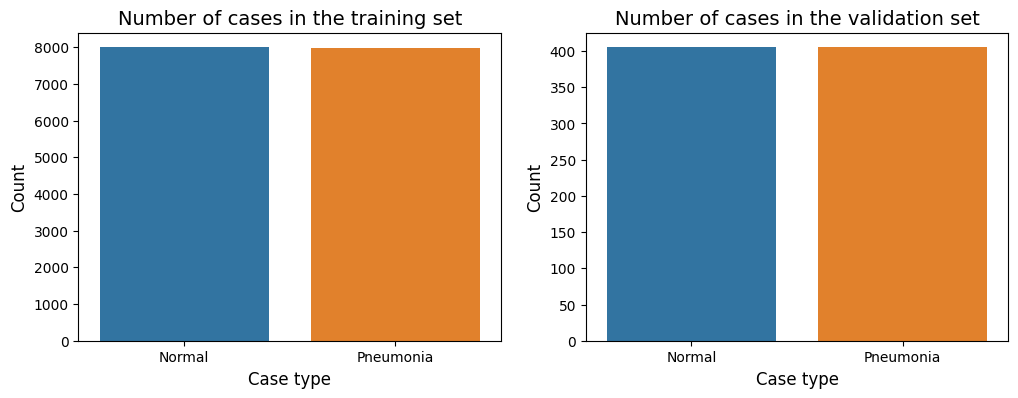

In [24]:
train_data = pd.DataFrame(train_p+train_n, columns=['image', 'label'],index=None)
val_data = pd.DataFrame(val_p+val_n, columns=['image', 'label'],index=None)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sb.countplot(data= train_data, x='label')
plt.title('Number of cases in the training set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_data.label.unique())), ['Normal', 'Pneumonia'])

plt.subplot(1,2,2)
sb.countplot(data= val_data, x='label')
plt.title('Number of cases in the validation set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_data.label.unique())), ['Normal', 'Pneumonia']);

In [25]:
Train_data=[]
Train_label=[]
for path in train_n+train_p:
    with Image.open(path[0]) as image_temp:
        img_array = img_to_array(image_temp)
        img_array = (img_array-img_array.mean())/img_array.std()
        img_array = img_array.reshape((1,)+img_array.shape)
        Train_data.append(img_array)
    Train_label.append(path[1])
Train_data = np.concatenate(Train_data, axis=0)
Train_label = np.array(Train_label)

Val_data=[]
Val_label=[]
for path in val_n+val_p:
    with Image.open(path[0]) as image_temp:
        img_array = img_to_array(image_temp)
        img_array = (img_array-img_array.mean())/img_array.std()
        img_array = img_array.reshape((1,)+img_array.shape)
        Val_data.append(img_array)
    Val_label.append(path[1])
Val_data = np.concatenate(Val_data, axis=0)
Val_label = np.array(Val_label)

Test_data=[]
Test_label=[]
for path in test_n+test_p:
    with Image.open(path[0]) as image_temp:
        img_array = img_to_array(image_temp)
        img_array = (img_array-img_array.mean())/img_array.std()
        img_array = img_array.reshape((1,)+img_array.shape)
        Test_data.append(img_array)
    Test_label.append(path[1])
Test_data = np.concatenate(Test_data, axis=0)
Test_label = np.array(Test_label)

In [26]:
Train_data, Train_label = shuffle(Train_data, Train_label, random_state=7)
Val_data, Val_label = shuffle(Val_data, Val_label, random_state=7)
Test_data, Test_label = shuffle(Test_data, Test_label, random_state=7)

**VGG ARCHITECTURE**

In [27]:
VGG_model = Sequential(name='VGG_model')
VGG_model.add(Conv2D(16,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal',
                       input_shape=(256,256,1) ))
VGG_model.add(MaxPooling2D((2,2), padding='same'))

VGG_model.add(Conv2D(32,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(Conv2D(32,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(BatchNormalization())
VGG_model.add(MaxPooling2D((2,2), strides=2 ,padding='same'))

VGG_model.add(Conv2D(64,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(Conv2D(64,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(BatchNormalization())
VGG_model.add(MaxPooling2D((2,2), strides=2 ,padding='same'))

VGG_model.add(Conv2D(128,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(Conv2D(128,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(BatchNormalization())
VGG_model.add(MaxPooling2D((2,2), strides=2 ,padding='same'))

VGG_model.add(Flatten())

VGG_model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
VGG_model.add(Dropout(0.15))
VGG_model.add(Dense(1, activation="sigmoid"))

VGG_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

VGG_model.summary()


Model: "VGG_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0 

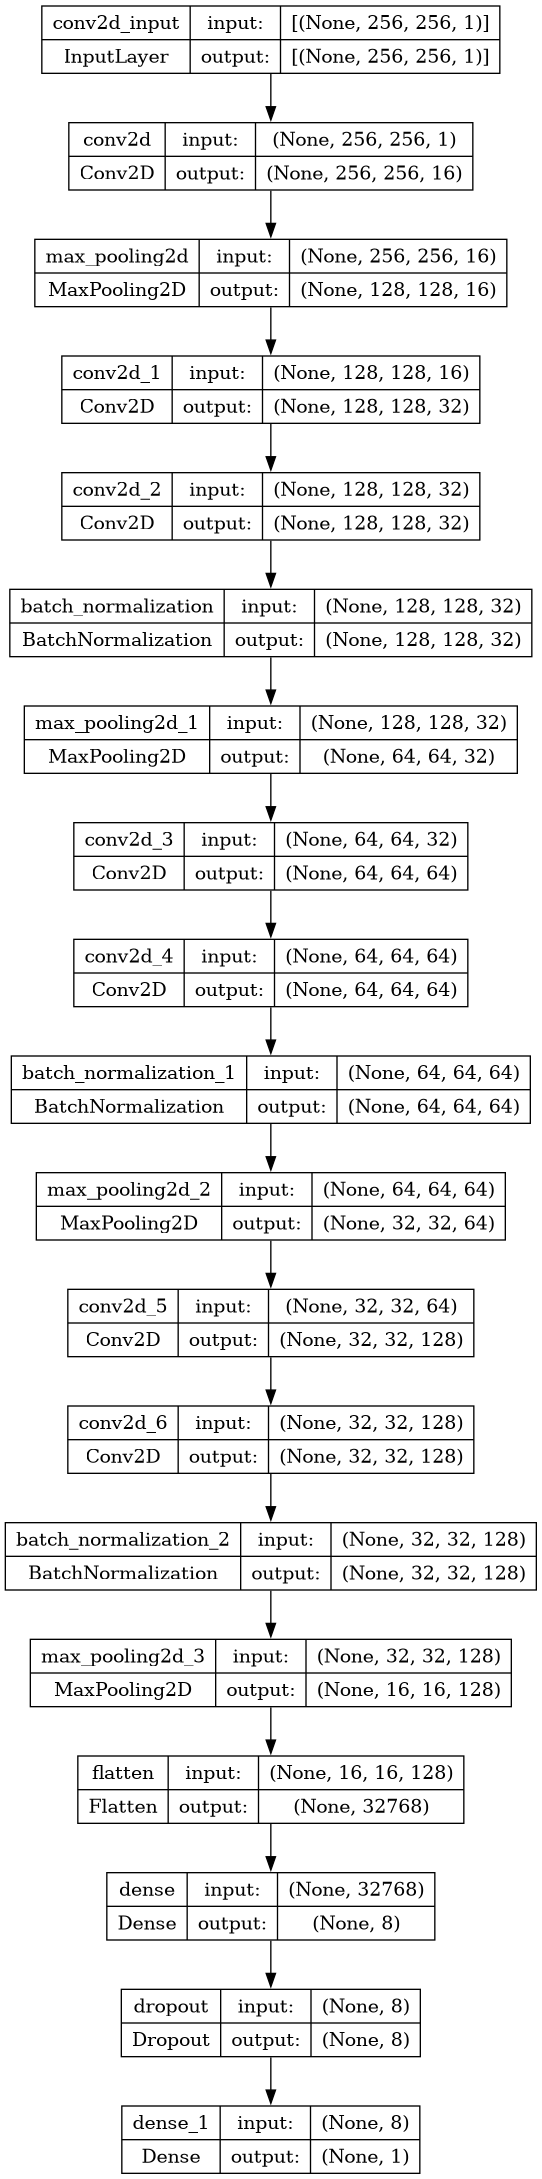

In [28]:
plot_model(VGG_model, show_shapes=True, to_file='VGG_model.png')

After some tuning of the hyper parameters, we've found that the follwoing ones gave the best results.

In [29]:
callback = ReduceLROnPlateau(monitor='val_loss', patience = 3, cooldown=0, verbose=1, factor=0.6, min_lr=0.000001)
start_vgg = time()
VGG_results = VGG_model.fit(
    x=Train_data,
    y=Train_label,
    batch_size=16,
    validation_data=(Val_data,Val_label),
    class_weight={0:12, 1:0.5},
    epochs=20, callbacks=[callback])
end_vgg = time()
vgg_train_dur = end_vgg - start_vgg

Epoch 1/20


I0000 00:00:1707028815.650016      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 [==============================] - 46s 33ms/step - loss: 0.7489 - accuracy: 0.5224 - val_loss: 0.8189 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
1000/1000 [==============================] - 31s 31ms/step - loss: 0.4968 - accuracy: 0.5148 - val_loss: 0.8178 - val_accuracy: 0.5148 - lr: 0.0010
Epoch 3/20
1000/1000 [==============================] - 31s 31ms/step - loss: 0.4713 - accuracy: 0.5180 - val_loss: 4.4906 - val_accuracy: 0.5296 - lr: 0.0010
Epoch 4/20
1000/1000 [==============================] - 31s 31ms/step - loss: 0.4700 - accuracy: 0.5133 - val_loss: 0.5879 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 5/20
1000/1000 [==============================] - 31s 31ms/step - loss: 0.4221 - accuracy: 0.6292 - val_loss: 0.4965 - val_accuracy: 0.5901 - lr: 0.0010
Epoch 6/20
1000/1000 [==============================] - 31s 31ms/step - loss: 0.3453 - accuracy: 0.7909 - val_loss: 0.2921 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 7/20
1000/1000 [==============================] - 3

**RESULTS**

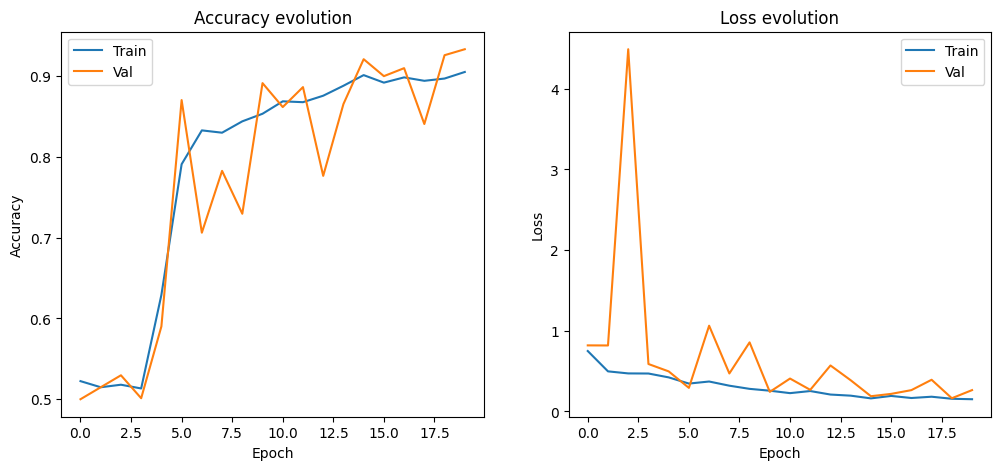

In [30]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(VGG_results.history['accuracy'])
plt.plot(VGG_results.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Accuracy evolution')

plt.subplot(122)
plt.plot(VGG_results.history['loss'])
plt.plot(VGG_results.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.title('Loss evolution');

In [31]:
print('Classification report:')
VGG_pred = VGG_model.predict(Test_data)
print(classification_report(VGG_pred.round(),Test_label))

Classification report:
20/20 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83       186
         1.0       0.97      0.87      0.92       438

    accuracy                           0.89       624
   macro avg       0.86      0.90      0.87       624
weighted avg       0.91      0.89      0.89       624



In [32]:
VGG_train_loss = VGG_results.history['loss']
VGG_val_loss = VGG_results.history['val_loss']
VGG_train_acc = VGG_results.history['accuracy']
VGG_val_acc = VGG_results.history['val_accuracy']

VGG_rep = classification_report(VGG_pred.round(),Test_label, output_dict=True)

Freeing up memory to be able to train next model

In [33]:
del VGG_model
del VGG_results
gc.collect()

8789

**INCEPTION ARCHITECTURE**

In [34]:
# Creating the inception module

def inception_module(layer_input, fb1, fb2_in, fb2_out, fb3_in, fb3_out, fb4_out):

    conv1 = Conv2D(fb1, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_input)

    conv3 = Conv2D(fb2_in, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_input)
    conv3 = Conv2D(fb2_out, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv3)

    conv5 = Conv2D(fb3_in, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_input)
    conv5 = Conv2D(fb3_out, (5,5), padding='same', activation='relu', kernel_initializer='he_normal')(conv5)

    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_input)
    pool = Conv2D(fb4_out, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(pool)

    layer_output = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_output

In [35]:
visible = Input(shape=(256,256,1))

layer = Conv2D(32, (7,7), strides=2, padding='same', activation='relu', kernel_initializer='he_normal' )(visible)
layer = MaxPooling2D((3,3), strides=(2,2))(layer)
layer = Lambda(tf.nn.local_response_normalization)(layer)
layer = Conv2D(32, (3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' )(layer)
layer = MaxPooling2D((3,3), strides=(2,2))(layer)
layer = inception_module(layer, 32, 64, 64, 16, 32, 32)
layer = inception_module(layer, 32, 64, 64, 16, 32, 32)
layer = MaxPooling2D((3,3), strides=(2,2), padding='same')(layer)
layer = Conv2D(32, (3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' )(layer)
layer = AveragePooling2D((3,3), padding='valid')(layer)
layer = Flatten()(layer)
layer = Dense(4, activation='relu', kernel_initializer='he_normal')(layer)
layer = Dense(1, activation='sigmoid')(layer)

Inception_model = Model(inputs=visible, outputs=layer, name='Inception_model')

Inception_model.summary()

Model: "Inception_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 128, 128, 32)         1600      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)           0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 lambda (Lambda)             (None, 63, 63, 32)           0         ['max_pooling2d_

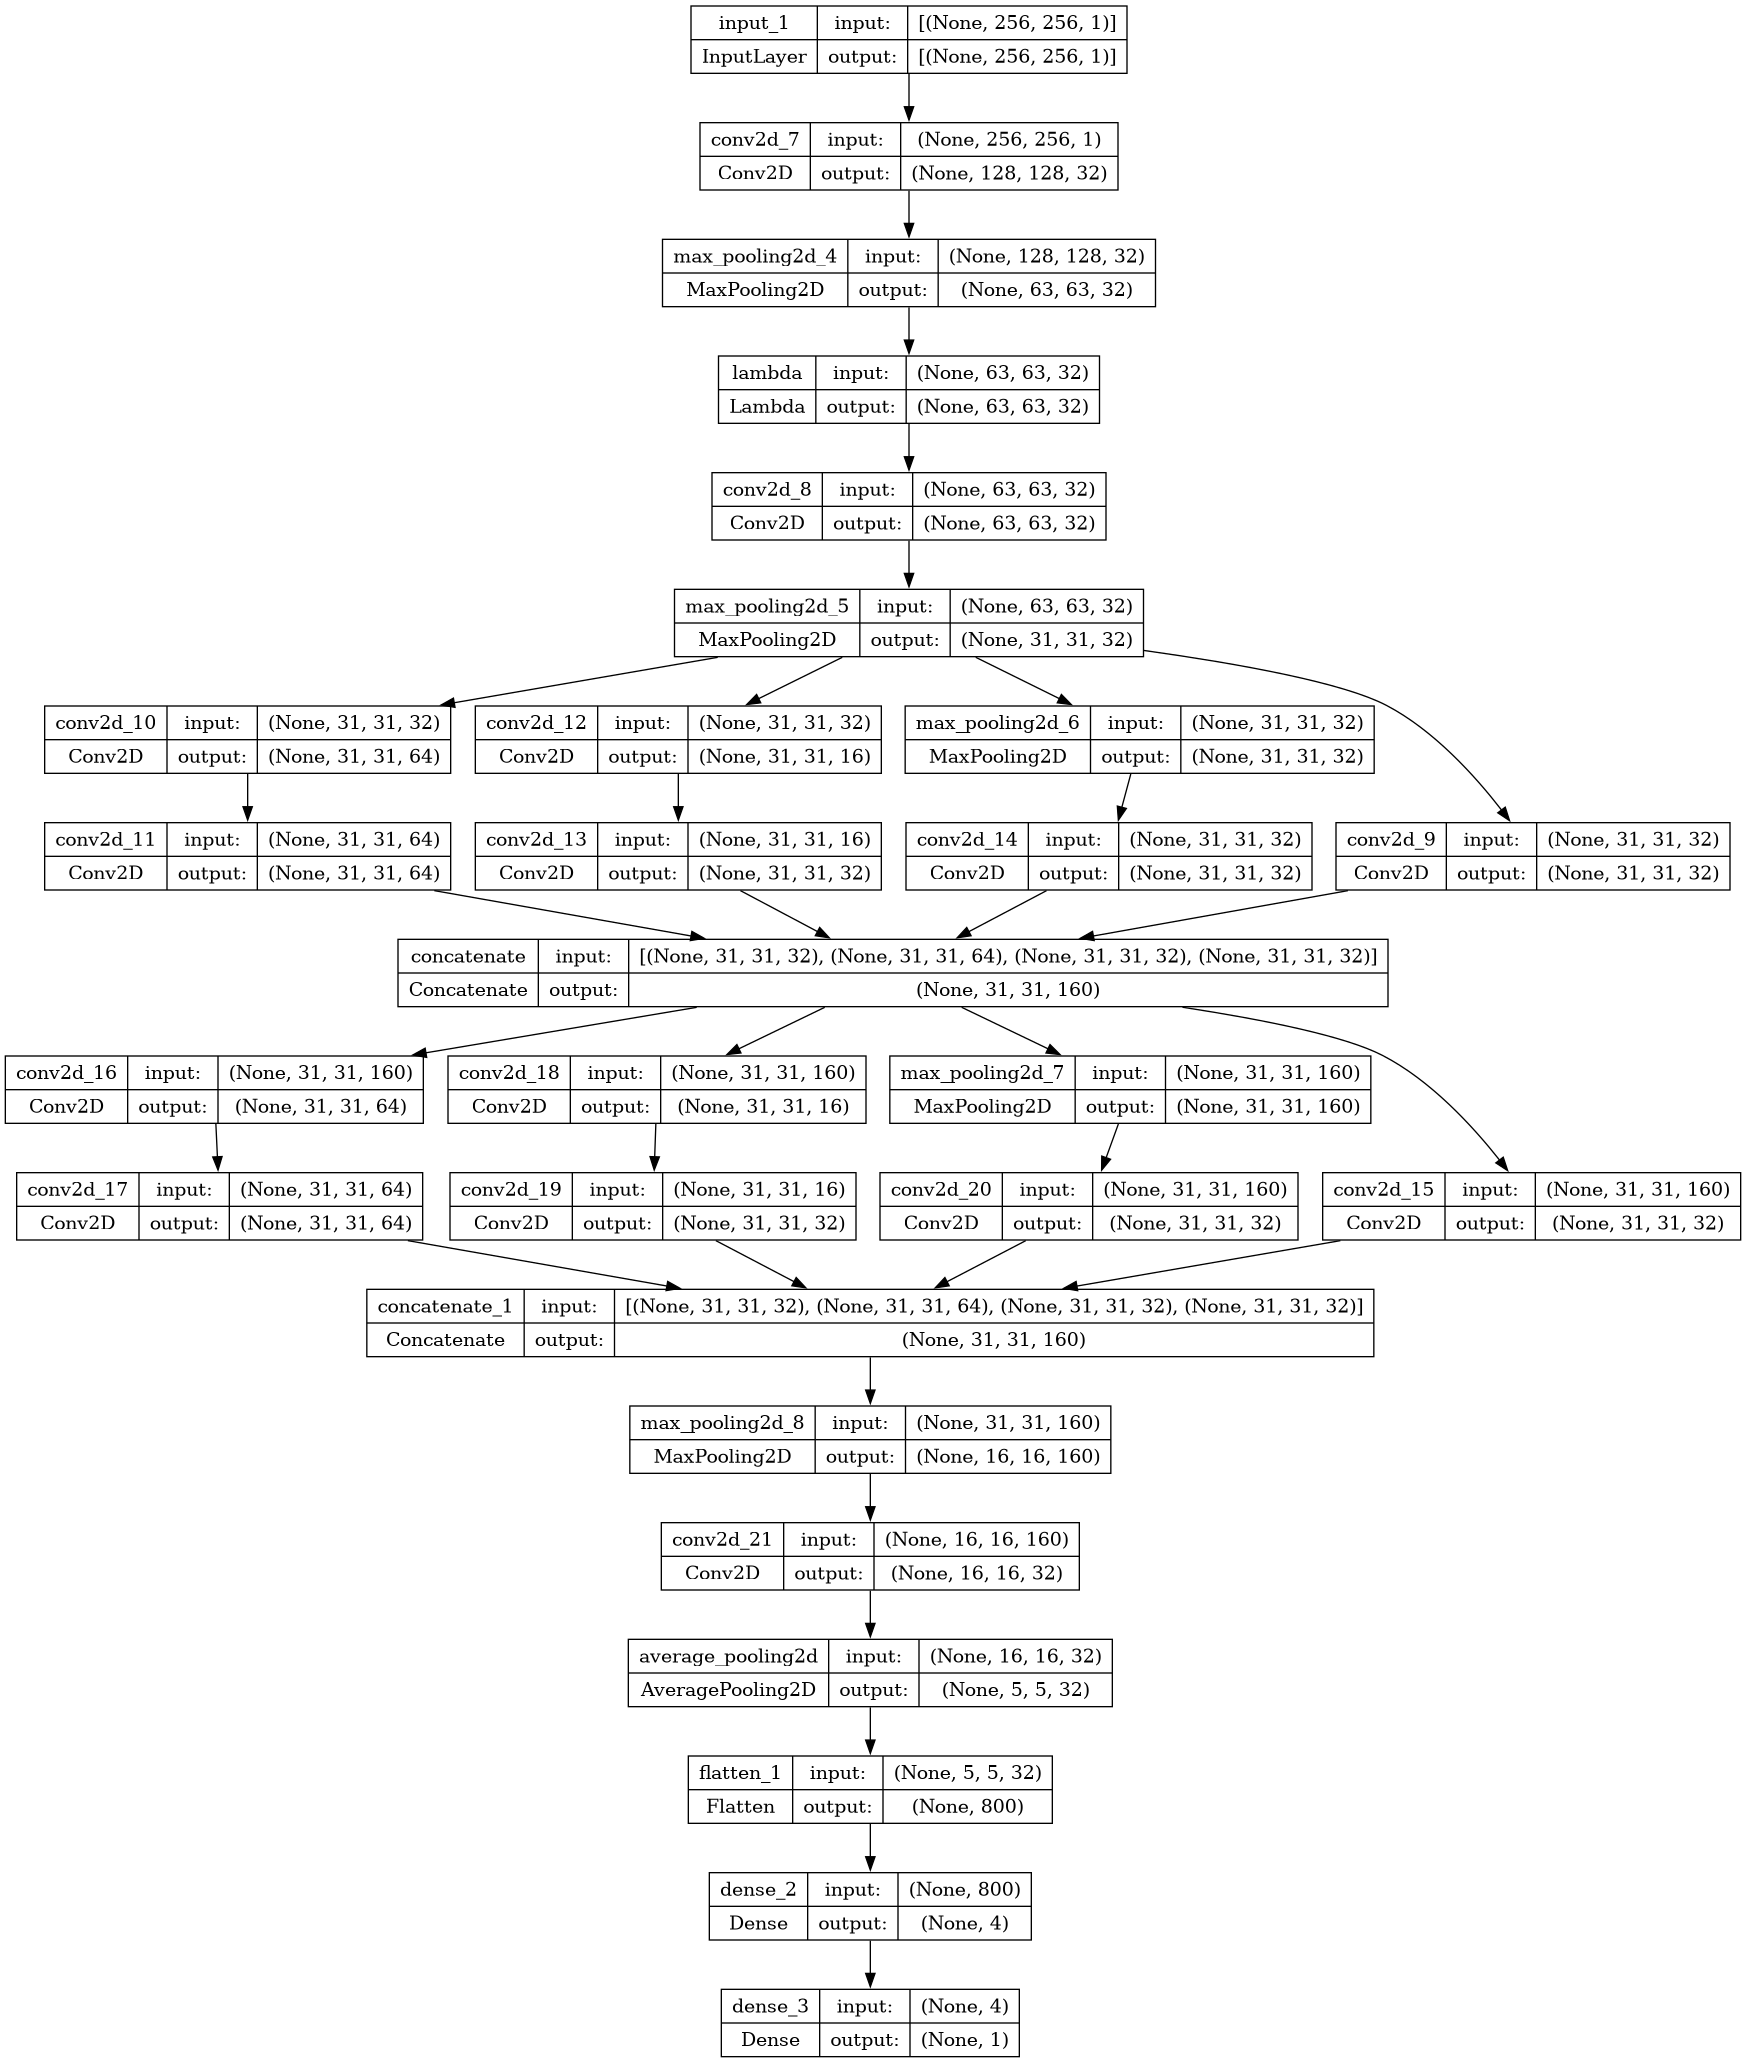

In [36]:
plot_model(Inception_model, show_shapes=True, to_file='inception_module.png')

In [37]:
Inception_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = ReduceLROnPlateau(monitor='val_loss', patience = 3, cooldown=0, verbose=1, factor=0.6, min_lr=0.000001)
start_inception = time()
results_inception = Inception_model.fit(
    x=Train_data,
    y=Train_label,
    batch_size=16,
    validation_data=(Val_data,Val_label),
    class_weight={0:12, 1:0.5},
    epochs=15, callbacks=[callback])
end_inception = time()
inception_train_dur = end_inception - start_inception

Epoch 1/15
1000/1000 [==============================] - 29s 22ms/step - loss: 0.5098 - accuracy: 0.7435 - val_loss: 0.6775 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 2/15
1000/1000 [==============================] - 21s 21ms/step - loss: 0.3528 - accuracy: 0.8580 - val_loss: 0.6935 - val_accuracy: 0.6568 - lr: 0.0010
Epoch 3/15
1000/1000 [==============================] - 21s 21ms/step - loss: 0.3062 - accuracy: 0.8691 - val_loss: 0.5427 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 4/15
1000/1000 [==============================] - 21s 21ms/step - loss: 0.2504 - accuracy: 0.9012 - val_loss: 0.5483 - val_accuracy: 0.7914 - lr: 0.0010
Epoch 5/15
1000/1000 [==============================] - 21s 21ms/step - loss: 0.2260 - accuracy: 0.8978 - val_loss: 0.5189 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 6/15
1000/1000 [==============================] - 21s 21ms/step - loss: 0.1735 - accuracy: 0.9231 - val_loss: 0.7324 - val_accuracy: 0.7123 - lr: 0.0010
Epoch 7/15
1000/1000 [========================

**RESULTS**

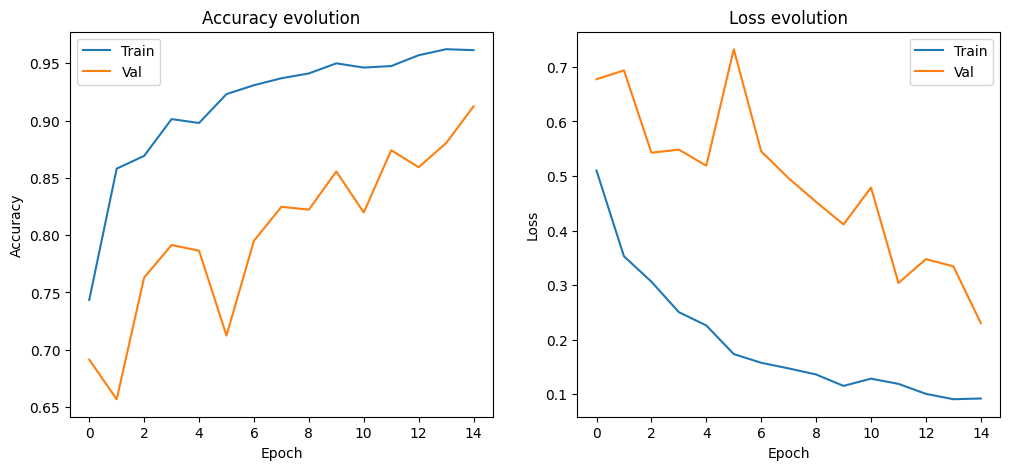

In [38]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(results_inception.history['accuracy'])
plt.plot(results_inception.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Accuracy evolution')

plt.subplot(122)
plt.plot(results_inception.history['loss'])
plt.plot(results_inception.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.title('Loss evolution');


In [39]:
print('Classification report:')
Inception_pred = Inception_model.predict(Test_data)
print(classification_report(Inception_pred.round(),Test_label))

Classification report:
20/20 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89       198
         1.0       0.98      0.90      0.94       426

    accuracy                           0.92       624
   macro avg       0.90      0.94      0.92       624
weighted avg       0.93      0.92      0.92       624



In [40]:
Inception_train_loss = results_inception.history['loss']
Inception_val_loss = results_inception.history['val_loss']
Inception_train_acc = results_inception.history['accuracy']
Inception_val_acc = results_inception.history['val_accuracy']

Inception_rep = classification_report(Inception_pred.round(),Test_label, output_dict=True)

Freeing up memory to be able to train next model

In [41]:
del Inception_model
del results_inception
gc.collect()

18001

**RESNET**

In [42]:
# function that will use the identity if possible, otherwise a projection of the number of filters
# in the input does not match the n_filters argument.

def residual_module(layer_in, n_filters):
    
    merge_input = layer_in
    if layer_in.shape[-1] != n_filters[2]:
        merge_input = Conv2D(n_filters[2], (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
        
    conv1 = Conv2D(n_filters[0], (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    conv2 = Conv2D(n_filters[1], (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv1)
    conv3 = Conv2D(n_filters[2], (1,1), padding='same', activation='linear', kernel_initializer='he_normal')(conv2)
    
    layer_out = add([conv3, merge_input])
    layer_out = Activation('relu')(layer_out)
    
    return layer_out

In [43]:
visible = Input(shape=(256,256,1))

layer = Conv2D(32, (7,7), strides=(2,2) ,padding='same', activation='relu', kernel_initializer='he_normal')(visible)
layer = MaxPooling2D((2,2), strides=2 ,padding='same')(layer)
layer = residual_module(layer, [8,8,16])
layer = residual_module(layer, [8,8,16])
layer = BatchNormalization()(layer)
layer = residual_module(layer, [8,8,16])
layer = residual_module(layer, [8,8,16])
layer = BatchNormalization()(layer)
layer = residual_module(layer, [16,16,32])
layer = residual_module(layer, [16,16,32])
layer = BatchNormalization()(layer)
layer = residual_module(layer, [32,32,64])
layer = residual_module(layer, [32,32,64])
layer = AveragePooling2D((3,3), padding='valid')(layer)
layer = Flatten()(layer)
layer = Dense(16, activation='relu')(layer)
layer = Dropout(0.1)(layer)
layer = Dense(1, activation='sigmoid')(layer)

ResNet_model = Model(inputs=visible, outputs=layer, name='ResNet_model')

ResNet_model.summary()

Model: "ResNet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 128, 128, 32)         1600      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)           0         ['conv2d_22[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_24 (Conv2D)          (None, 64, 64, 8)            264       ['max_pooling2d_9[0

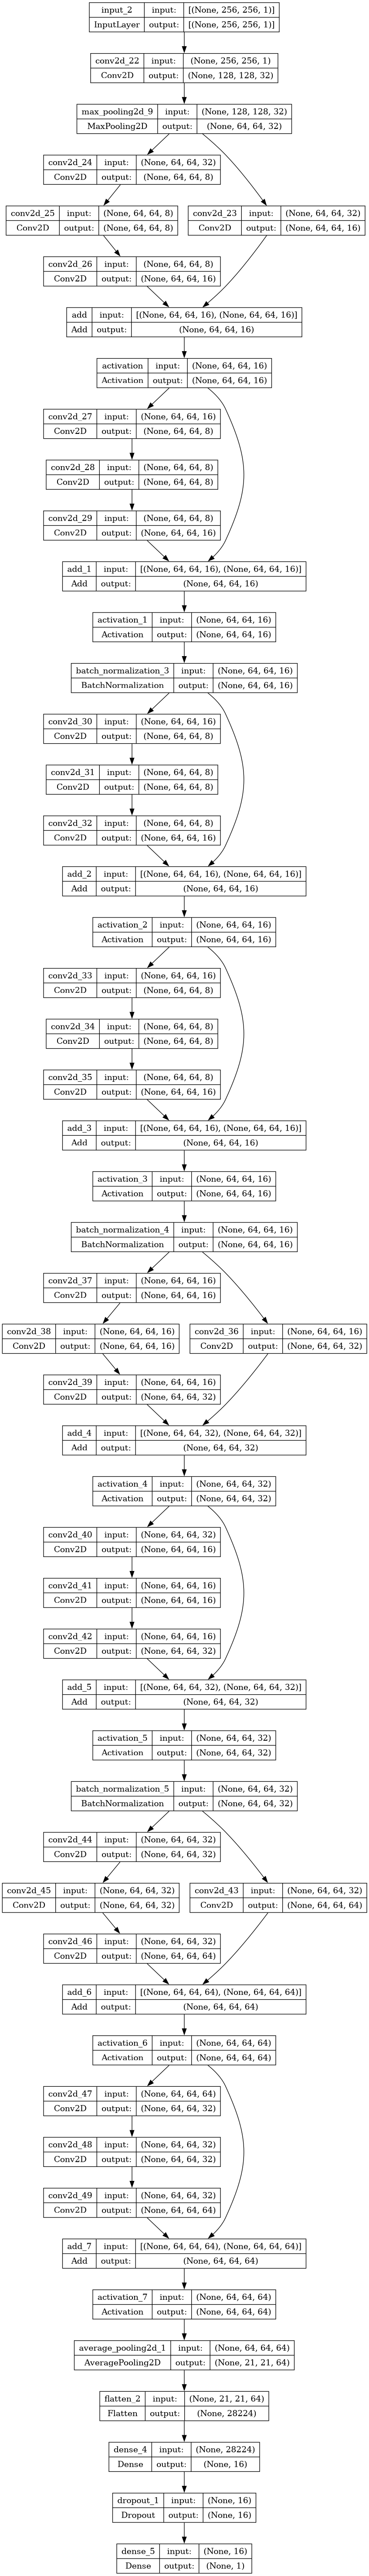

In [44]:
plot_model(ResNet_model, show_shapes=True, to_file='ResNet_module.png')

In [45]:
ResNet_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = ReduceLROnPlateau(monitor='val_loss', patience = 2, cooldown=0, verbose=1, factor=0.6, min_lr=0.000001)
start_ResNet = time()
results_ResNet = ResNet_model.fit(
    x=Train_data,
    y=Train_label,
    batch_size=16,
    validation_data=(Val_data,Val_label),
    class_weight={0:20, 1:0.5},
    epochs=15, callbacks=[callback])
end_ResNet = time()
ResNet_train_dur = end_ResNet - start_ResNet

Epoch 1/15
1000/1000 [==============================] - 40s 29ms/step - loss: 0.8293 - accuracy: 0.6122 - val_loss: 0.9570 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 2/15
1000/1000 [==============================] - 27s 27ms/step - loss: 0.4770 - accuracy: 0.7891 - val_loss: 0.8706 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 3/15
1000/1000 [==============================] - 27s 27ms/step - loss: 0.4121 - accuracy: 0.7835 - val_loss: 0.7810 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 4/15
1000/1000 [==============================] - 27s 27ms/step - loss: 0.3907 - accuracy: 0.7902 - val_loss: 0.6742 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 5/15
1000/1000 [==============================] - 27s 27ms/step - loss: 0.3522 - accuracy: 0.8060 - val_loss: 0.5335 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 6/15
1000/1000 [==============================] - 27s 27ms/step - loss: 0.3164 - accuracy: 0.8273 - val_loss: 1.2090 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 7/15
1000/1000 [========================

**RESULTS**

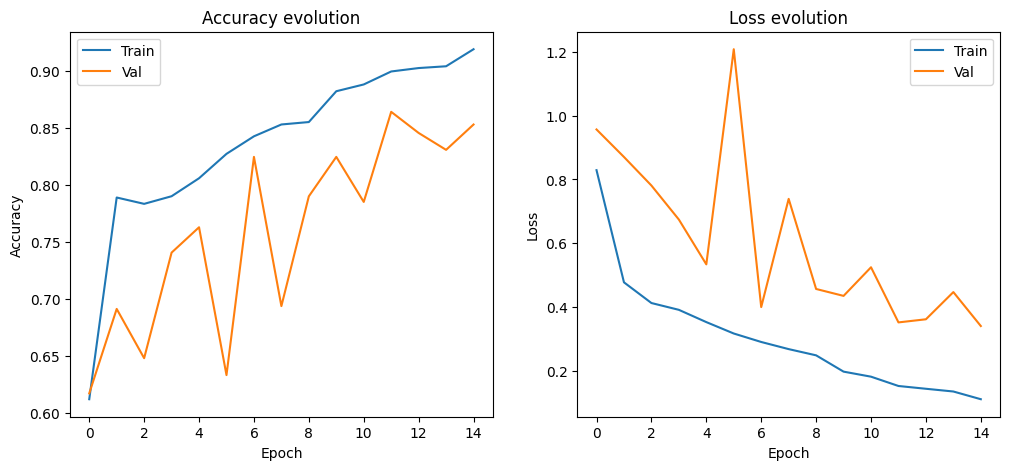

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(results_ResNet.history['accuracy'])
plt.plot(results_ResNet.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Accuracy evolution')

plt.subplot(122)
plt.plot(results_ResNet.history['loss'])
plt.plot(results_ResNet.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.title('Loss evolution');

In [47]:
print('Classification report:')
ResNet_pred = ResNet_model.predict(Test_data)
print(classification_report(ResNet_pred.round(),Test_label))

Classification report:
20/20 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84       191
         1.0       0.97      0.87      0.92       433

    accuracy                           0.89       624
   macro avg       0.86      0.90      0.88       624
weighted avg       0.90      0.89      0.89       624



In [48]:
ResNet_train_loss = results_ResNet.history['loss']
ResNet_val_loss = results_ResNet.history['val_loss']
ResNet_train_acc = results_ResNet.history['accuracy']
ResNet_val_acc = results_ResNet.history['val_accuracy']

ResNet_rep = classification_report(ResNet_pred.round(),Test_label, output_dict=True)

In [49]:
del ResNet_model
del results_ResNet
gc.collect()

29848

**FINAL COMPARISON**

Evolution of the validation Loss/Accuracy of the three trained models:

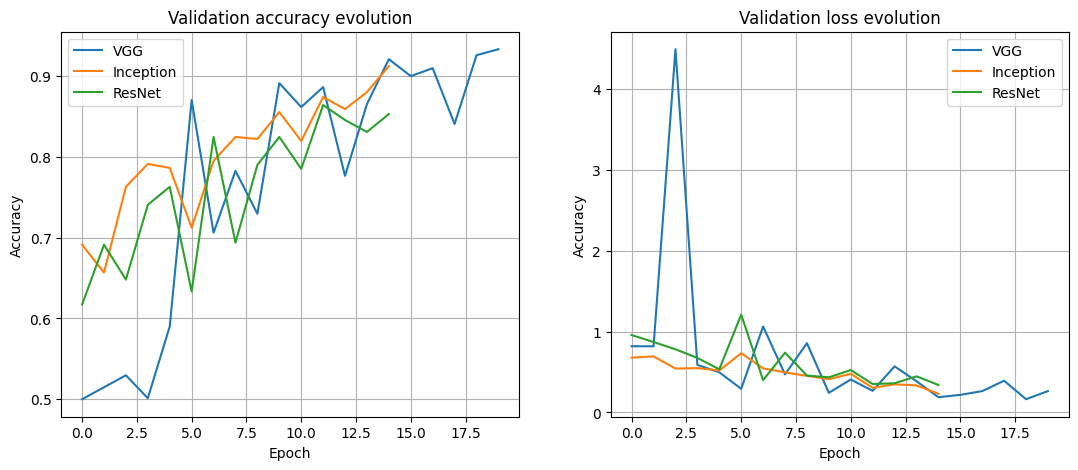

In [50]:
plt.figure(figsize=(13,5))

plt.subplot(121)
plt.plot(VGG_val_acc)
plt.plot(Inception_val_acc)
plt.plot(ResNet_val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['VGG','Inception','ResNet'])
plt.title('Validation accuracy evolution')
plt.grid(True)


plt.subplot(122)
plt.plot(VGG_val_loss)
plt.plot(Inception_val_loss)
plt.plot(ResNet_val_loss)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['VGG','Inception','ResNet'])
plt.title('Validation loss evolution')
plt.grid(True);

In [51]:
# Function to plot the confusion matrix of the trained model.

def plot_cm(mat,y_ture):
    df_cm = pd.DataFrame(mat, columns=np.unique(y_ture), index = np.unique(y_ture))
    df_cm.index.name = 'True Label'
    df_cm.columns.name = 'Predicted Label'
    sb.heatmap(df_cm, cmap="Blues", cbar=False, annot=True,annot_kws={"size": 10})
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

Normalized confusion matrix of each model

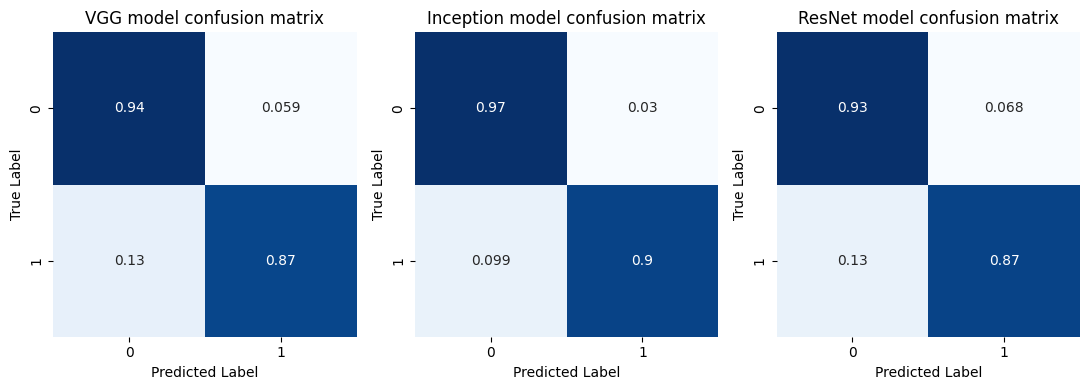

In [52]:
plt.figure(figsize=(11,4))
plt.subplot(131)
plot_cm(confusion_matrix(VGG_pred.round(),Test_label, normalize='true'), Test_label)
plt.title('VGG model confusion matrix')
plt.subplot(132)
plot_cm(confusion_matrix(Inception_pred.round(),Test_label, normalize='true'), Test_label)
plt.title('Inception model confusion matrix')
plt.subplot(133)
plot_cm(confusion_matrix(ResNet_pred.round(),Test_label, normalize='true'), Test_label)
plt.title('ResNet model confusion matrix')
plt.tight_layout()

Summary table of the three trained models results

In [53]:
vgg_acc = round(VGG_rep['accuracy'],2)
inception_acc = round(Inception_rep['accuracy'],2)
resnet_acc = round(ResNet_rep['accuracy'],2)

vgg_normal_f1 = round(VGG_rep['0.0']['f1-score'],2)
inception_normal_f1 = round(Inception_rep['0.0']['f1-score'],2)
resnet_normal_f1 = round(ResNet_rep['0.0']['f1-score'],2)

vgg_pneu_f1 = round(VGG_rep['1.0']['f1-score'],2)
inception_pneu_f1 = round(Inception_rep['1.0']['f1-score'],2)
resnet_pneu_f1 = round(ResNet_rep['1.0']['f1-score'],2)


print('Comparaison of model results:')

result_table=[['Model','Training epochs' ,'Training duration (min)', 'Test accuracy', '(Normal) F1-score', '(Pneumonia) F1-score'],
             ['VGG model', 20, round(vgg_train_dur/60), vgg_acc, vgg_normal_f1, vgg_pneu_f1],
             ['Inception model', 15,round(inception_train_dur/60), inception_acc, inception_normal_f1, inception_normal_f1],
             ['ResNet model ', 15,round(ResNet_train_dur/60), resnet_acc, resnet_normal_f1, resnet_pneu_f1]]

display(HTML(tabulate.tabulate(result_table, colalign=("center",)*6, tablefmt='html')))

Comparaison of model results:


# CONCLUSION

In this pneumonia detection task, we've used three CNN architectures and compared their results. With very similar hyper-parameters, the inception architecture gave the best results on the test set. It's possible to increase the performance of these models by further optimizing the hyper-parameters and using more sophisticated callbacks, such as EarlyStopping.